In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from numpy import pi
from pandas import DataFrame
from fractions import Fraction

In [2]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2, 7, 8, 11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [3]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

# Step 1.

## $
\begin{split}
f(x) &= 7^x           &\mod 15 \\
f(4) &= 2401 \equiv 1 &\mod 15 \\
f(x+4) &\equiv f(x)    &\mod 15
\end{split}
$

## $f$ is periodic. $_\#$

In [4]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
# The first 8-qubit register for storing x
qr1 = QuantumRegister(n_count, name="q1")
# The second 4-qubit register for storing f(x)
qr2 = QuantumRegister(4, name="q2")
cr1 = ClassicalRegister(n_count, name="c1")
cr2 = ClassicalRegister(4, name="c2")
qc = QuantumCircuit(qr1, qr2, cr1, cr2)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3 + n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Step 2.

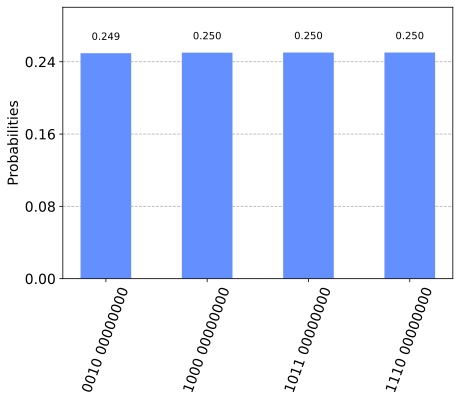

In [5]:
qc.measure(qr2, cr2)

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

## The results are 2, 8, 11, and 14.

# Step 3.

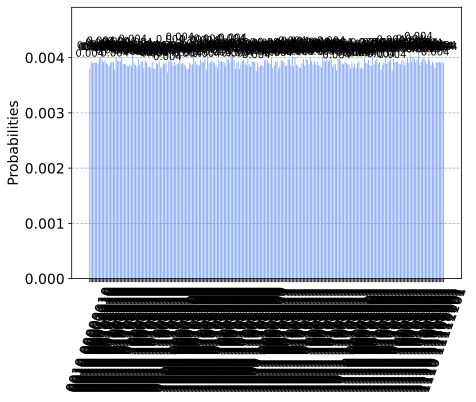

In [6]:
qc.measure(qr1, cr1)
qc.measure(qr2, cr2)

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

# Step 4.

In [7]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
# The first 8-qubit register for storing x
qr1 = QuantumRegister(n_count, name="q1")
# The second 4-qubit register for storing f(x)
qr2 = QuantumRegister(4, name="q2")
cr1 = ClassicalRegister(n_count, name="c1")
# cr2 = ClassicalRegister(4, name="c2")
qc = QuantumCircuit(qr1, qr2, cr1)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3 + n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

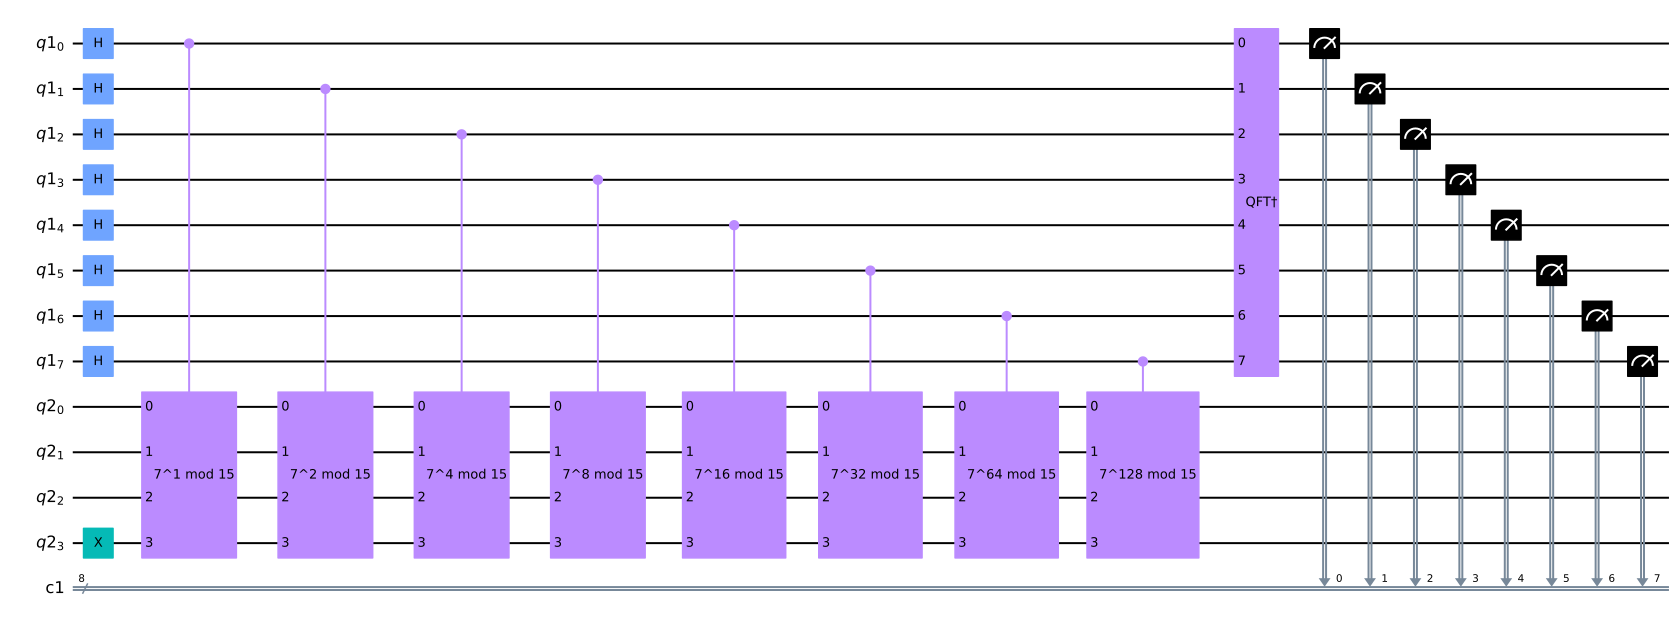

In [8]:
# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold' 

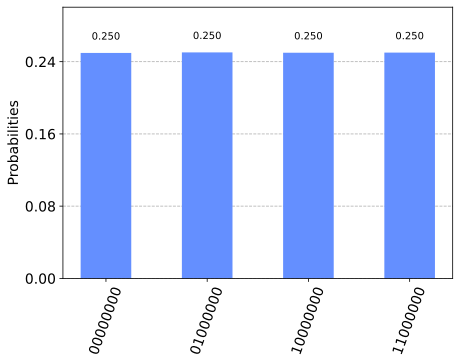

In [9]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [10]:
for output in counts:
    decimal = int(output, 2) # Convert (base 2) string to decimal
    print(decimal)

0
64
128
192


# Step 5.

In [11]:
rows, measured_phases = [], []

for output in counts:
    decimal = int(output, 2) # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])

# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


## $r = 4$, correct!

# Try a = 2

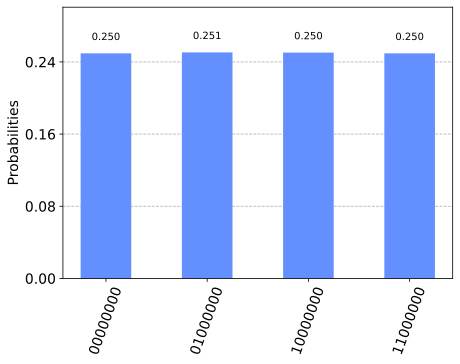

In [12]:
n_count = 8
a = 2

qr1 = QuantumRegister(n_count, name="q1")
qr2 = QuantumRegister(4, name="q2")
cr1 = ClassicalRegister(n_count, name="c1")
qc = QuantumCircuit(qr1, qr2, cr1)

for q in range(n_count):
    qc.h(q)

qc.x(3 + n_count)

for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

qc.append(qft_dagger(n_count), range(n_count))

qc.measure(range(n_count), range(n_count))

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [13]:
rows, measured_phases = [], []

for output in counts:
    decimal = int(output, 2) # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])

# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.75      3/4            4
2   0.25      1/4            4
3   0.50      1/2            2


## $r = 4$, correct!

# Try a = 8

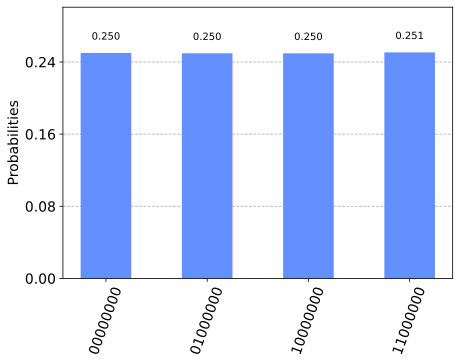

In [14]:
n_count = 8
a = 8

qr1 = QuantumRegister(n_count, name="q1")
qr2 = QuantumRegister(4, name="q2")
cr1 = ClassicalRegister(n_count, name="c1")
qc = QuantumCircuit(qr1, qr2, cr1)

for q in range(n_count):
    qc.h(q)

qc.x(3 + n_count)

for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

qc.append(qft_dagger(n_count), range(n_count))

qc.measure(range(n_count), range(n_count))

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [15]:
rows, measured_phases = [], []

for output in counts:
    decimal = int(output, 2) # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])

# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.50      1/2            2
2   0.75      3/4            4
3   0.25      1/4            4


## $r = 4$, correct!

# Try a = 11

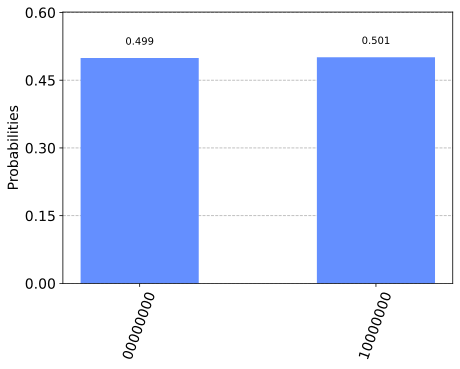

In [16]:
n_count = 8
a = 11

qr1 = QuantumRegister(n_count, name="q1")
qr2 = QuantumRegister(4, name="q2")
cr1 = ClassicalRegister(n_count, name="c1")
qc = QuantumCircuit(qr1, qr2, cr1)

for q in range(n_count):
    qc.h(q)

qc.x(3 + n_count)

for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

qc.append(qft_dagger(n_count), range(n_count))

qc.measure(range(n_count), range(n_count))

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [17]:
rows, measured_phases = [], []

for output in counts:
    decimal = int(output, 2) # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])

# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0    0.0      0/1            1
1    0.5      1/2            2


## $r = 2$, correct!

# Try a = 13

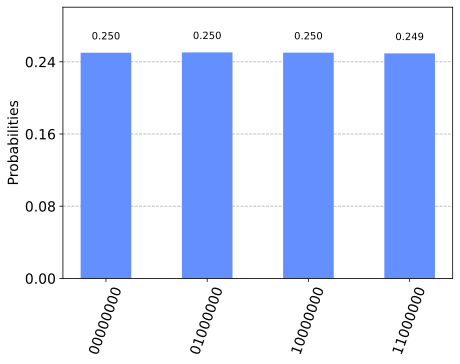

In [18]:
n_count = 8
a = 13

qr1 = QuantumRegister(n_count, name="q1")
qr2 = QuantumRegister(4, name="q2")
cr1 = ClassicalRegister(n_count, name="c1")
qc = QuantumCircuit(qr1, qr2, cr1)

for q in range(n_count):
    qc.h(q)

qc.x(3 + n_count)

for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

qc.append(qft_dagger(n_count), range(n_count))

qc.measure(range(n_count), range(n_count))

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [19]:
rows, measured_phases = [], []

for output in counts:
    decimal = int(output, 2) # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])

# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.75      3/4            4
2   0.50      1/2            2
3   0.25      1/4            4


## $r = 4$, correct!